# Tabnet Hyperoptimization

In [1]:
import pandas as pd
from load_data import *
from matplotlib import pyplot as plt
%matplotlib inline
import tabnet
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns 
%matplotlib inline
from sklearn.model_selection import KFold

In [2]:
def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  
  return r2

In [3]:
def transform(ds):
    features = tf.unstack(ds["features"])
    prices = ds["price"]

    x = dict(zip(col_names, features))
    y = prices
    return x, y

## Selected Variables

### Output and Feature Dimension
Output and Feature dimension have a large impact on performance, so do the optimization only concerning them

In [8]:
url_listing = "http://data.insideairbnb.com/ireland/leinster/dublin/2021-11-07/data/listings.csv.gz"
listings = pd.read_csv(url_listing)
# remove extreme prices
price = listings["price"]
price = price.str.replace("$","")
price = price.str.replace(",","")
price = price.astype(float)
filter = price < 500
listings = listings[filter]
X_train, _ = train_test_split(listings, random_state = 123, test_size = 0.2)
X_train = X_train.reset_index(drop = True)

What I want to Grid search for

In [ ]:
ods = [30, 40, 50, 60, 70, 80, 90, 100, 110, 120] 
fds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
overview_mae = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_mse = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_r2 = pd.DataFrame(np.zeros((len(ods), len(fds))))
overview_mae.columns = fds
overview_mae.index = ods
overview_mse.columns = fds
overview_mse.index = ods
overview_r2.columns = fds
overview_r2.index = ods

In [ ]:
kf = KFold(n_splits=5)
cv_run = 0
fold_data = {}

In [ ]:
for i in ods:
    for j in fds:
        
        mae_min = []
        mse_min = []
        r2_max = []

        kf = KFold(n_splits=5, shuffle=True, random_state=1234)
        for train_index, test_index in kf.split(X_train):
            c = 0    
            print("TRAIN:", train_index, "TEST:", test_index)

            # Data
            if cv_run > 0:
                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = fold_data[str(c)]
            else:
                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_cv(train_idx = train_index, val_idx = test_index)
            

            bin_col = [col for col in X_train_kf if np.isin(X_train_kf[col].unique(), [0, 1]).all()]
            num_col = [col for col in X_train_kf if ~np.isin(X_train_kf[col].unique(), [0, 1]).all()]
            col_names = bin_col + num_col

            train_size = int(X_train_kf.shape[0] * 0.9)
            batch_size = int(X_train_kf.shape[0] * 0.1)

            data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
            data_train = data_train.shuffle(6000, seed = 13)
            train_dataset = data_train.take(len(X_train_kf))
            train_dataset = train_dataset.map(transform)
            train_dataset = train_dataset.batch(batch_size)

            data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
            test_dataset = data_test.take(len(X_val_kf))
            test_dataset = test_dataset.map(transform)
            test_dataset = test_dataset.batch(batch_size)

            feature_columns = []

            for col in col_names:
                feature_columns.append(tf.feature_column.numeric_column(col))


            model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=i, feature_dim=i+j, num_groups=1,
                                            num_decision_steps=2)
                                            
            lr = 0.01
            optimizer = tf.keras.optimizers.Adam(lr)
            model.compile(optimizer, loss=['mse'] , metrics=[R_squared, "mse", "mae"])

            hist_model = model.fit(train_dataset, epochs=50, 
                                validation_data=test_dataset, verbose=1)

            mae_min.append(np.min(hist_model.history["val_mae"]))
            mse_min.append(np.min(hist_model.history["val_mse"]))
            r2_max.append(np.max(hist_model.history["val_R_squared"]))

            # save fold data
            if cv_run == 0:
                fold_data[str(c)] = [X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf]
            c += 1

        cv_run += 1
        mae_min_m = np.mean(mae_min)
        mse_min_m = np.mean(mse_min)
        r2_max_m = np.mean(r2_max)

        overview_mae.at[i, j] = mae_min_m
        overview_mse.at[i, j] = mse_min_m
        overview_r2.at[i, j] = r2_max_m

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
11/11 [==============================] - 1s 84ms/step - loss: 0.3966 - R_squared: 0.0725 - mse: 0.3966 - mae: 0.5047 - val_loss: 0.4965 - val_R_squared: -0.1517 - val_mse: 0.4965 - val_mae: 0.5582
TRAIN: [   0    3    4 ... 5409 5410 5411] TEST: [   1    2    5 ... 5392 5400 5403]
[TabNet]: 1 features will be used for decision steps.
Epoch 1/50
11/11 [==============================] - 6s 202ms/step - loss: 3.8716 - R_squared: -6.9748 - mse: 3.8716 - mae: 1.3715 - val_loss: 0.6304 - val_R_squared: -0.4738 - val_mse: 0.6304 - val_mae: 0.6307
Epoch 2/50
11/11 [==============================] - 1s 83ms/step - loss: 0.5420 - R_squared: -0.2130 - mse: 0.5420 - mae: 0.5839 - val_loss: 0.5393 - val_R_squared: -0.2326 - val_mse: 0.5393 - val_mae: 0.5861
Epoch 3/50
11/11 [==============================] - 1s 78ms/step - loss: 0.4855 - R_squared: -0.1631 - mse: 0.4855 - mae: 0.5566 - val_loss: 0.4481 - val_R_squared: -0.0308 - val

In [ ]:
fds_ind = ["+1", "+2", "+3", "+4", "+5", "+6", "+7", "+8", "+9", "+10"] # for a better labeling of the resulting heatmap
overview_mae.columns = fds_ind
overview_mse.columns = fds_ind
overview_r2.columns = fds_ind

In [ ]:
overview_mae.to_csv("TabNet_GS_selected_1_mae.csv")
overview_mse.to_csv("TabNet_GS_selected_1_mse.csv")
overview_r2.to_csv("TabNet_GS_selected_1_r2.csv")

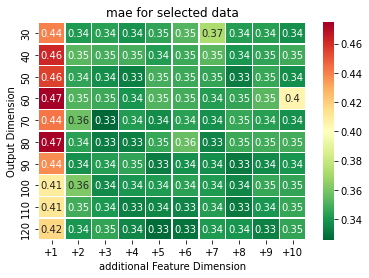

In [ ]:
sns.heatmap(overview_mae, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("additional Feature Dimension")
plt.ylabel("Output Dimension")
plt.savefig("TabNet_GS_selected_1_mae", drpi = 300)

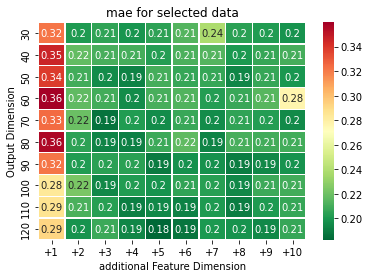

In [ ]:
sns.heatmap(overview_mse, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("additional Feature Dimension")
plt.ylabel("Output Dimension")
plt.savefig("TabNet_GS_selected_1_mse", drpi = 300)

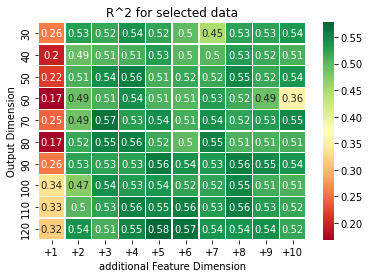

In [ ]:
sns.heatmap(overview_r2, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("additional Feature Dimension")
plt.ylabel("Output Dimension")
plt.savefig("TabNet_GS_selected_1_r2", drpi = 300)

In [ ]:
best_idx = np.unravel_index(np.argmax(overview_r2, axis=None), overview_r2.shape)
od = ods[best_idx[0]]
fd = od + fds[best_idx[1]]

Now steps and relaxation factor.

In [ ]:
nds = [2, 3, 4, 5, 6, 7, 8, 9, 10]
rf = [1, 1.5, 2, 2.5, 3, 3.5]

In [ ]:
overview_mae_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_mse_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_r2_2 = pd.DataFrame(np.zeros((len(nds), len(rf))))
overview_mae_2.columns = rf
overview_mae_2.index = nds
overview_mse_2.columns = rf
overview_mse_2.index = nds
overview_r2_2.columns = rf
overview_r2_2.index = nds

In [ ]:
kf = KFold(n_splits=5)
cv_run = 0
fold_data = {}

In [ ]:
for i in nds:
    for j in rf:
        
        mae_min = []
        mse_min = []
        r2_max = []
           
        
        kf = KFold(n_splits=5, shuffle=True, random_state=1234)
        for train_index, test_index in kf.split(X_train):
            c = 0   
            print("TRAIN:", train_index, "TEST:", test_index)
            # Data
            if cv_run > 0:
                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = fold_data[str(c)]
            else:
                X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_cv(train_idx = train_index, val_idx = test_index)

            train_size = int(X_train_kf.shape[0] * 0.9)
            batch_size = int(X_train_kf.shape[0] * 0.1)

            bin_col = [col for col in X_train_kf if np.isin(X_train_kf[col].unique(), [0, 1]).all()]
            num_col = [col for col in X_train_kf if ~np.isin(X_train_kf[col].unique(), [0, 1]).all()]
            col_names = bin_col + num_col

            data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
            data_train = data_train.shuffle(6000, seed = 13)
            train_dataset = data_train.take(len(X_train_kf))
            train_dataset = train_dataset.map(transform)
            train_dataset = train_dataset.batch(batch_size)

            data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
            test_dataset = data_test.take(len(X_val_kf))
            test_dataset = test_dataset.map(transform)
            test_dataset = test_dataset.batch(batch_size)

            feature_columns = []

            for col in col_names:
                feature_columns.append(tf.feature_column.numeric_column(col))

            model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=od, feature_dim=fd, num_groups=1,
                                            num_decision_steps=i, relaxation_factor=j)
                                            
            lr = 0.01
            optimizer = tf.keras.optimizers.Adam(lr)
            model.compile(optimizer, loss=['mse'] , metrics=[R_squared, "mse", "mae"])

            hist_model = model.fit(train_dataset, epochs=50,
                                validation_data=test_dataset, verbose=1)

            mae_min.append(np.min(hist_model.history["val_mae"]))
            mse_min.append(np.min(hist_model.history["val_mse"]))
            r2_max.append(np.max(hist_model.history["val_R_squared"]))
            # save fold data
            if cv_run == 0:
                fold_data[str(c)] = [X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf]
            c += 1

        cv_run += 1
        mae_min_m = np.mean(mae_min)
        mse_min_m = np.mean(mse_min)
        r2_max_m = np.mean(r2_max)

        overview_mae_2.at[i, j] = mae_min_m
        overview_mse_2.at[i, j] = mse_min_m
        overview_r2_2.at[i, j] = r2_max_m

TRAIN: [   1    2    3 ... 5409 5410 5411] TEST: [   0    8   14 ... 5388 5401 5406]
[TabNet]: 5 features will be used for decision steps.
Epoch 1/50
11/11 [==============================] - 10s 240ms/step - loss: 3.2791 - R_squared: -45.3335 - mse: 3.2791 - mae: 1.2747 - val_loss: 0.6938 - val_R_squared: -0.5595 - val_mse: 0.6938 - val_mae: 0.6533
Epoch 2/50
11/11 [==============================] - 1s 75ms/step - loss: 0.5643 - R_squared: -1.3823 - mse: 0.5643 - mae: 0.5984 - val_loss: 0.4911 - val_R_squared: -0.1013 - val_mse: 0.4911 - val_mae: 0.5532
Epoch 3/50
11/11 [==============================] - 1s 76ms/step - loss: 0.5131 - R_squared: -0.1506 - mse: 0.5131 - mae: 0.5469 - val_loss: 0.4543 - val_R_squared: -0.0272 - val_mse: 0.4543 - val_mae: 0.5444
Epoch 4/50
11/11 [==============================] - 1s 78ms/step - loss: 0.3542 - R_squared: 0.2443 - mse: 0.3542 - mae: 0.4674 - val_loss: 0.3386 - val_R_squared: 0.2210 - val_mse: 0.3386 - val_mae: 0.4505
Epoch 5/50
11/11 [======

/content/drive/MyDrive/Dominik/NEW/load_data.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["bath_number"] = bath_number.astype(float)
/content/drive/MyDrive/Dominik/NEW/load_data.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data["bath_kind"] = bath_kind


Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
11/11 [==============================] - 2s 166ms/step - loss: 0.3943 - R_squared: 0.0015 - mse: 0.3943 - mae: 0.4986 - val_loss: 0.3937 - val_R_squared: 0.0973 - val_mse: 0.3937 - val_mae: 0.4950
TRAIN: [   0    3    4 ... 5409 5410 5411] TEST: [   1    2    5 ... 5392 5400 5403]
[TabNet]: 5 features will be used for decision steps.
Epoch 1/50
11/11 [==============================] - 27s 551ms/step - loss: 6.9493 - R_squared: -14.2783 - mse: 6.9493 - mae: 1.8505 - val_loss: 1.2839 - val_R_squared: -1.9913 - val_mse: 1.2839 - val_mae: 0.9091
Epoch 2/50
11/11 [==============================] - 2s 166ms/step - loss: 1.1069 - R_squared: -1.4871 - mse: 1.1069 - mae: 0.8423 - val_loss: 0.6994 - val_R_squared: -0.6182 - val_mse: 0.6994 - val_mae: 0.6744
Epoch 3/50
11/11 [==============================] - 2s 163ms/step - loss: 0.5987 - R_squared: -0.3704 - mse: 0.5987 - mae: 0.6199 - val_loss: 0.6338 - val_R_squared: -0.4749 -

In [ ]:
overview_mae_2.to_csv("TabNet_GS_selected_2_mae.csv")
overview_mse_2.to_csv("TabNet_GS_selected_2_mse.csv")
overview_r2_2.to_csv("TabNet_GS_selected_2_r2.csv")

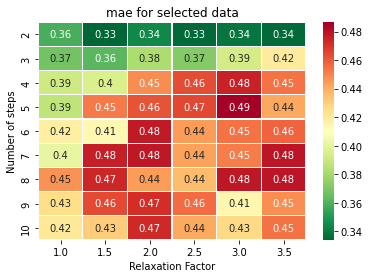

In [ ]:
sns.heatmap(overview_mae_2, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("Relaxation Factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_GS_selected_2_mae.png", drpi = 300)

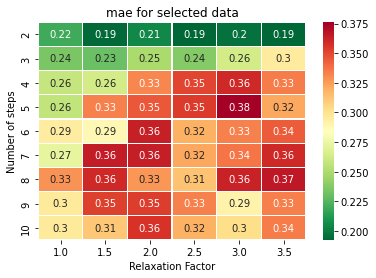

In [ ]:
sns.heatmap(overview_mse_2, cmap ='RdYlGn_r', linewidths = 0.30, annot = True)
plt.title("mae for selected data")
plt.xlabel("Relaxation Factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_GS_selected_2_mse.png", drpi = 300)

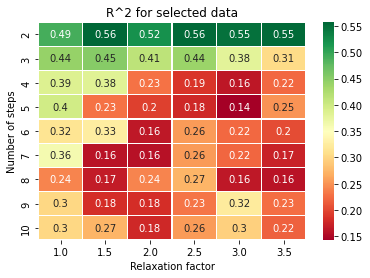

In [ ]:
sns.heatmap(overview_r2_2, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Relaxation factor")
plt.ylabel("Number of steps")
plt.savefig("TabNet_GS_selected_2_r2.png", drpi = 300)

In [ ]:
best_idx = np.unravel_index(np.argmax(overview_r2_2, axis=None), overview_r2_2.shape)
nds = nds[best_idx[0]]
rf = rf[best_idx[1]]

In [ ]:
print(nds)
print(rf)

2
1.5


In [ ]:
sc = [ 1e-2, 1e-3, 1e-4, 1e-5]
overview_mae_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_mse_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_r2_3 = pd.DataFrame(np.zeros((1, len(sc))))
overview_mae_3.columns = sc
overview_mse_3.columns = sc
overview_r2_3.columns = sc

In [ ]:
cv_run = 0
fold_data = {}

In [ ]:
for j in sc:
        
    mae_min = []
    mse_min = []
    r2_max = []

    kf = KFold(n_splits=5, shuffle=True, random_state=1234)
    for train_index, test_index in kf.split(X_train):
        c = 0    
        print("TRAIN:", train_index, "TEST:", test_index)

        # Data
        if cv_run > 0:
            X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = fold_data[str(c)]
        else:
            X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_cv(train_idx = train_index, val_idx = test_index)
        

        bin_col = [col for col in X_train_kf if np.isin(X_train_kf[col].unique(), [0, 1]).all()]
        num_col = [col for col in X_train_kf if ~np.isin(X_train_kf[col].unique(), [0, 1]).all()]
        col_names = bin_col + num_col

        train_size = int(X_train_kf.shape[0] * 0.9)
        batch_size = int(X_train_kf.shape[0] * 0.1)

        data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
        data_train = data_train.shuffle(6000, seed = 13)
        train_dataset = data_train.take(len(X_train_kf))
        train_dataset = train_dataset.map(transform)
        train_dataset = train_dataset.batch(batch_size)

        data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
        test_dataset = data_test.take(len(X_val_kf))
        test_dataset = test_dataset.map(transform)
        test_dataset = test_dataset.batch(batch_size)

        feature_columns = []

        for col in col_names:
            feature_columns.append(tf.feature_column.numeric_column(col))

        model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                            output_dim=od, feature_dim=fd, num_groups=1,
                                            num_decision_steps=nds, relaxation_factor=rf,
                                            sparsity_coefficient=j)
                                            
        lr = 0.01
        optimizer = tf.keras.optimizers.Adam(lr)
        model.compile(optimizer, loss=['mse'] , metrics=[R_squared, "mse", "mae"])

        hist_model = model.fit(train_dataset, epochs=50,
                                validation_data=test_dataset, verbose=1)

        mae_min.append(np.min(hist_model.history["val_mae"]))
        mse_min.append(np.min(hist_model.history["val_mse"]))
        r2_max.append(np.max(hist_model.history["val_R_squared"]))
        # save fold data
        if cv_run == 0:
          fold_data[str(c)] = [X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf]
        c += 1

    mae_min_m = np.mean(mae_min)
    mse_min_m = np.mean(mse_min)
    r2_max_m = np.mean(r2_max)

    overview_mae_3.at[0, j] = mae_min_m
    overview_mse_3.at[0, j] = mse_min_m
    overview_r2_3.at[0, j] = r2_max_m

TRAIN: [   1    2    3 ... 5409 5410 5411] TEST: [   0    8   14 ... 5388 5401 5406]
[TabNet]: 5 features will be used for decision steps.
Epoch 1/50
11/11 [==============================] - 9s 226ms/step - loss: 4.0826 - R_squared: -91.6919 - mse: 4.0826 - mae: 1.3788 - val_loss: 0.8488 - val_R_squared: -0.9434 - val_mse: 0.8488 - val_mae: 0.7403
Epoch 2/50
11/11 [==============================] - 1s 79ms/step - loss: 0.7043 - R_squared: -1.8435 - mse: 0.7043 - mae: 0.6729 - val_loss: 0.5476 - val_R_squared: -0.2388 - val_mse: 0.5476 - val_mae: 0.5855
Epoch 3/50
11/11 [==============================] - 1s 77ms/step - loss: 0.4819 - R_squared: -0.1229 - mse: 0.4819 - mae: 0.5628 - val_loss: 0.4486 - val_R_squared: -0.0203 - val_mse: 0.4486 - val_mae: 0.5379
Epoch 4/50
11/11 [==============================] - 1s 75ms/step - loss: 0.4757 - R_squared: -0.1099 - mse: 0.4757 - mae: 0.5464 - val_loss: 0.4168 - val_R_squared: 0.0551 - val_mse: 0.4168 - val_mae: 0.5191
Epoch 5/50
11/11 [======

In [ ]:
overview_mae_3.to_csv("TabNet_GS_selected_3_mae.csv")
overview_mse_3.to_csv("TabNet_GS_selected_3_mse.csv")
overview_r2_3.to_csv("TabNet_GS_selected_3_r2.csv")

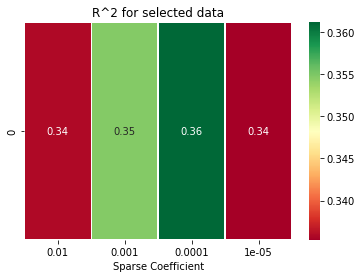

In [ ]:
sns.heatmap(overview_mae_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")
plt.savefig("TabNet_GS_selected_3_mae.png", drpi = 300)

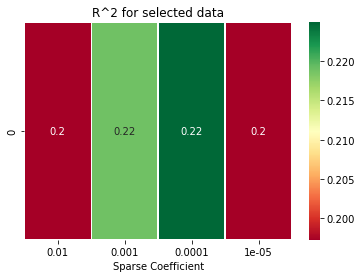

In [ ]:
sns.heatmap(overview_mse_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")
plt.savefig("TabNet_GS_selected_3_mse.png", drpi = 300)

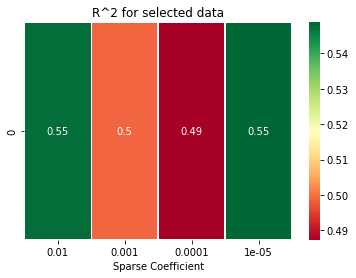

In [ ]:
sns.heatmap(overview_r2_3, cmap ='RdYlGn', linewidths = 0.30, annot = True)
plt.title("R^2 for selected data")
plt.xlabel("Sparse Coefficient")
plt.ylabel("")
plt.savefig("TabNet_GS_selected_3_r2.png", drpi = 300)

In [ ]:
best_idx = np.unravel_index(np.argmax(overview_r2_3, axis=None), overview_r2_3.shape)
sc = sc[best_idx[1]]

# Final Model

In [2]:
print("Best Output Dimension: ", od)
print("Best Feature Dimension: ", fd)
print("Best Number of steps: ", nds)
print("Best relaxation factor: ", rf)
print("Best sparsity coefficient: ", sc)

Best Output Dimension:  120
Best Feature Dimension:  125
Best Number of steps:  2
Best relaxation factor:  1.5
Best sparsity coefficient:  1e-05


In [ ]:
mae_min = []
mse_min = []
r2_max = []
c = 0  
epo = 100

kf = KFold(n_splits=5, shuffle=True, random_state=1234)
for train_index, test_index in kf.split(X_train):
    print(c)
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train_kf, X_test, X_val_kf, y_train_kf, y_test, y_val_kf = load_data_cv(train_idx = train_index, val_idx = test_index)

    train_size = int(X_train_kf.shape[0] * 0.9)
    batch_size = int(X_train_kf.shape[0] * 0.1)

    data_train = tf.data.Dataset.from_tensor_slices({"features": X_train_kf, "price": y_train_kf})
    data_train = data_train.shuffle(6000, seed = 13)
    train_dataset = data_train.take(len(X_train_kf))
    train_dataset = train_dataset.map(transform)
    train_dataset = train_dataset.batch(batch_size)

    data_test = tf.data.Dataset.from_tensor_slices({"features": X_val_kf, "price": y_val_kf})
    test_dataset = data_test.take(len(X_val_kf))
    test_dataset = test_dataset.map(transform)
    test_dataset = test_dataset.batch(batch_size)

    feature_columns = []

    for col in col_names:
        feature_columns.append(tf.feature_column.numeric_column(col))

    model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                    output_dim=od, feature_dim=fd, num_groups=1,
                                    num_decision_steps=nds, relaxation_factor=rf,
                                    sparsity_coefficient=sc)

    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f"TabNet_GS/best_model{c}.hdf5",
                                                    monitor='val_R_squared',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    save_weights_only=True,
                                                    mode='max')
                                            
    lr = 0.01
    optimizer = tf.keras.optimizers.Adam(lr)
    model.compile(optimizer, loss=['mse'] , metrics=[R_squared, "mse", "mae"])

    hist_model = model.fit(train_dataset, epochs=epo,
                           validation_data=test_dataset, verbose=1,
                            callbacks=[checkpoint])

    print("Fitted model", c+1)
    mae_min.append(np.min(hist_model.history["val_mae"]))
    mse_min.append(np.min(hist_model.history["val_mse"]))
    r2_max.append(np.max(hist_model.history["val_R_squared"]))

    if c > 0:
        if mae_min[c] < mae_min[c -1]:
            X_train_bestfold = X_train_kf
            X_val_bestfold = X_val_kf
            y_train_bestfold = y_train_kf
            y_val_bestfold = y_val_kf

    hist_df = pd.DataFrame(hist_model.history)
    hist_csv_file = f'history_TabNet_final{c}.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    print("Saved.")
    c += 1

print("The minimum mae is", np.min(mae_min), "and got achieved at the", np.argmin(mae_min) + 1, "model.")
print("The minimum mse is", np.min(mse_min), "and got achieved at the", np.argmin(mse_min) + 1, "model.")
print("The maximum R2 is", np.max(r2_max), "and got achieved at the", np.argmax(r2_max) + 1, "model.")

0
TRAIN: [   1    2    3 ... 5409 5410 5411] TEST: [   0    8   14 ... 5388 5401 5406]
[TabNet]: 5 features will be used for decision steps.
Epoch 1/100
10/11 [==========================>...] - ETA: 0s - loss: 3.3206 - R_squared: -7.1220 - mse: 3.3206 - mae: 1.2715
Epoch 1: val_R_squared improved from -inf to -1.54988, saving model to TabNet_GS/best_model0.hdf5
11/11 [==============================] - 13s 281ms/step - loss: 3.3193 - R_squared: -41.7428 - mse: 3.3193 - mae: 1.2712 - val_loss: 1.1172 - val_R_squared: -1.5499 - val_mse: 1.1172 - val_mae: 0.8641
Epoch 2/100
11/11 [==============================] - ETA: 0s - loss: 0.6507 - R_squared: -0.6595 - mse: 0.6507 - mae: 0.6386
Epoch 2: val_R_squared improved from -1.54988 to -0.34427, saving model to TabNet_GS/best_model0.hdf5
11/11 [==============================] - 1s 83ms/step - loss: 0.6507 - R_squared: -0.6595 - mse: 0.6507 - mae: 0.6386 - val_loss: 0.5932 - val_R_squared: -0.3443 - val_mse: 0.5932 - val_mae: 0.6056
Epoch 3/10

In [ ]:
bf = np.argmax(r2_max) + 1

In [6]:
X_train, X_test, X_val, y_train, y_test, y_val = load_data_fold(fold=bf)

In [ ]:
hist_model5 = pd.read_csv(f"TabNet_GS/history_TabNet_final{bf-1}.csv")

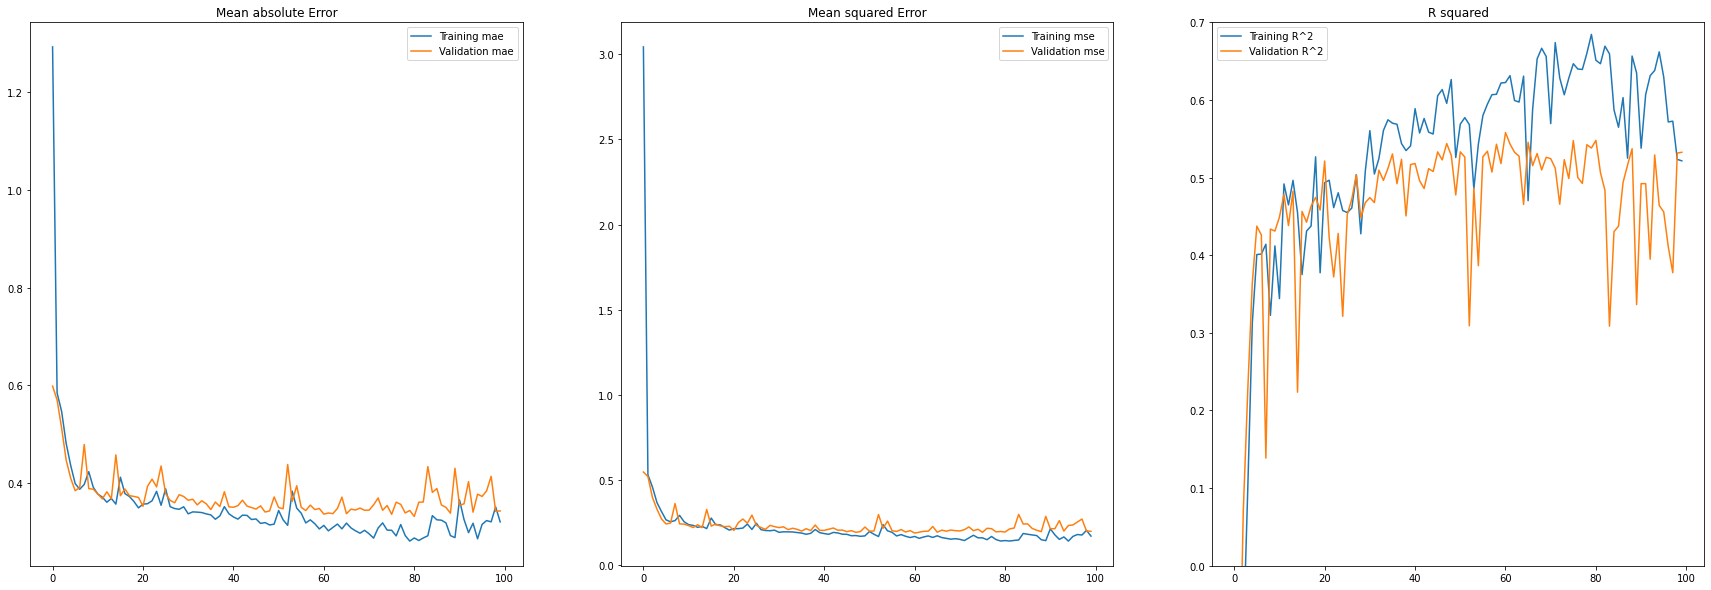

In [ ]:
epochs_range = range(epo)
fig, axs = plt.subplots(1, 3, figsize=(30, 10))
axs[0].plot(epochs_range, hist_model5["mae"], label="Training mae")
axs[0].plot(epochs_range, hist_model5["val_mae"], label="Validation mae")
axs[0].set_title("Mean absolute Error")
axs[0].legend(loc='best')

axs[1].plot(epochs_range, hist_model5["mse"], label="Training mse")
axs[1].plot(epochs_range, hist_model5["val_mse"], label="Validation mse")
axs[1].set_title("Mean squared Error")
axs[1].legend(loc='best')

axs[2].plot(epochs_range, hist_model5["R_squared"], label="Training R^2")
axs[2].plot(epochs_range, hist_model5["val_R_squared"], label="Validation R^2")
axs[2].set_ylim((0, 0.7))
axs[2].set_title("R squared")
#axs[2].axhline(y = 0.6, color = "red")
axs[2].legend(loc='best')

plt.savefig("TabNet_GS/TabNet_Selected_Final.png")

# Load best model

In [13]:
X_train, X_test, X_val, y_train, y_test, y_val = load_data_fold(fold=bf)

In [7]:
def transform(ds):
    features = tf.unstack(ds["features"])
    prices = ds["price"]

    x = dict(zip(col_names, features))
    y = prices
    return x, y

def R_squared(y, y_pred):
  residual = tf.reduce_sum(tf.square(tf.subtract(y, y_pred)))
  total = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))
  r2 = tf.subtract(1.0, tf.math.divide(residual, total))
  
  return r2

bin_col = [col for col in X_train if np.isin(X_train[col].unique(), [0, 1]).all()]
num_col = [col for col in X_train if ~np.isin(X_train[col].unique(), [0, 1]).all()]
col_names = bin_col + num_col

train_size = int(X_train.shape[0] * 0.9)
batch_size = int(X_train.shape[0] * 0.1)

data_train = tf.data.Dataset.from_tensor_slices({"features": X_train, "price": y_train})
data_train = data_train.shuffle(6000, seed = 13)
train_dataset = data_train.take(len(X_train))
train_dataset = train_dataset.map(transform)
train_dataset = train_dataset.batch(batch_size)

data_test = tf.data.Dataset.from_tensor_slices({"features": X_val, "price": y_val})
test_dataset = data_test.take(len(X_val))
test_dataset = test_dataset.map(transform)
test_dataset = test_dataset.batch(batch_size)


feature_columns = []

for col in col_names:
    feature_columns.append(tf.feature_column.numeric_column(col))


od = 120
fd = 125
nds = 2
rf = 1.5
sc = 1e-05
epo = 1

lr = tf.keras.optimizers.schedules.ExponentialDecay(0.01, decay_steps=100, decay_rate=0.95, staircase=False)
#lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)

model = tabnet.TabNetRegression(feature_columns, num_regressors=1,
                                output_dim=od, feature_dim=fd, num_groups=1,
                                num_decision_steps=nds, relaxation_factor=rf,
                                sparsity_coefficient=sc)

model.compile(optimizer, loss=['mse'] , metrics=[R_squared, "mse", "mae"])

hist_model = model.fit(train_dataset, epochs=epo, 
                        validation_data=test_dataset, verbose=1)

model.load_weights(f"TabNet_Selected/best_model{bf-1}.hdf5")

[TabNet]: 5 features will be used for decision steps.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

10/10 [==============================] - 4s 419ms/step - loss: 3.4947 - R_squared: -6.9866 - mse: 3.4947 - mae: 1.2742 - val_loss: 0.4701 - val_R_squared: -0.0517 - val_mse: 0.4701 - val_mae: 0.5539


In [ ]:
model.summary()

Model: "tab_net_regressor_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tab_net_300 (TabNet)        multiple                  177121    
                                                                 
 regressor (Dense)           multiple                  120       
                                                                 
Total params: 177,241
Trainable params: 177,241
Non-trainable params: 0
_________________________________________________________________
Model: "tab_net_300"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_features_300 (DenseFe  multiple                 0         
 atures)                                                         
                                                                 
 input_gn (GroupNormalizatio  multiple                 138       
 n)               

In [15]:
data_testing = tf.data.Dataset.from_tensor_slices({"features": X_test, "price": y_test})
testing_dataset = data_testing.take(len(X_test))
testing_dataset = testing_dataset.map(transform)
testing_dataset = testing_dataset.batch(X_test.shape[0])

In [16]:
y_pred = model.predict(testing_dataset)

In [17]:
model.evaluate(testing_dataset, verbose=1)

1/1 [==============================] - 0s 195ms/step - loss: 0.1846 - R_squared: 0.5350 - mse: 0.1846 - mae: 0.3270


[0.1846247911453247,
 0.5350176095962524,
 0.1846247911453247,
 0.3269636929035187]

# Shap Values for best model

In [8]:
import shap

In [9]:
# also unnormalized data
_, X_test_shap, _, _, _, _ = load_data_fold(fold=bf, for_dendro=True, standardize=False)

In [10]:
# define pipeline function
def f(x):
  tmp = pd.DataFrame(x, columns = X_test.columns)
  tmp = tmp.to_dict("series")
  return(model.predict(tmp))

In [11]:
# masker and explainer 
masker = shap.maskers.Independent(X_test.values, max_samples=100)
explainer = shap.explainers.Permutation(f, masker)

In [12]:
def get_aggr_shap(values):
    
    feat = values.feature_names 
    filter = pd.Series(feat).str.contains(r"_pca").values
    feat_pca = np.array(feat)[filter].tolist()
    
    splits = np.unique(pd.Series(feat_pca).str.split((r"_pca\d|_pca$"), expand = True).values[:,0])
    new_feat = values.feature_names
    new_values = values.values
    new_data = values.data
    for i in splits:
        regex_filter = pd.Series(new_feat).str.contains(i).values
        # drop feature names
        new_feat = np.array(new_feat)[~regex_filter].tolist()
        new_feat.append(i)
        
        # aggregated values
        values_filtered = new_values[:,np.where(regex_filter)[0].tolist()]   
        values_aggr = values_filtered.sum(axis = 1)
        # drop values
        new_values = new_values[:,  np.where(~regex_filter)[0].tolist()]
        #new_values = np.concatenate((new_values, values_aggr), axis = 0)
        new_values = np.c_[new_values, values_aggr]
        
        # alter data matrix
        new_data = new_data[:,  np.where(~regex_filter)[0].tolist()]
        new_data = np.c_[new_data, np.repeat(np.NaN,new_data.shape[0])]

    values.feature_names=new_feat
    values.values = new_values
    values.data = new_data
    #values.data[:,-len(splits):] = np.full((values.data.shape[0], len(splits)), np.NaN)
    
    # replace data of non pca variables with actual values
    col_raw = X_test_shap.columns.tolist()
    col_shap = values.feature_names
    col_new = []
    for i in col_raw:
        if i in col_shap:
            col_new.append(i)
    
    for i in col_new:
        index_shap = np.where(np.array(col_shap) == i)
        values.data[:,index_shap] = X_test_shap[i].values.reshape((X_test_shap[i].values.shape[0],1,1))
    
    return values

In [13]:
# compute shap_values
shap_values = explainer(X_test.values)



Permutation explainer: 1322it [4:52:59, 13.31s/it]                            


In [14]:
# adjust base_value
shap_values.base_values = shap_values.base_values[0][0]
shap_values.feature_names = X_test.columns

In [24]:
print(X_test_shap.loc[[8,588],["room_type_Private_room", "room_type_Entire_home/apt", 
                    "bath_number_1", "bath_number_2", "bath_kind_Shared", "bath_kind_Private", "bath_kind_Normal",
                    "bedrooms_1", "bedrooms_2", "accommodates", "beds", 
                    "property_type_Private_room_in_residential_home", "property_type_Entire_rental_unit",
                    "property_type_Private_room_in_rental_unit", "property_type_Entire_residential_home"]].T.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  8   &  588 \\
\midrule
room\_type\_Private\_room                         &  1.0 &  0.0 \\
room\_type\_Entire\_home/apt                      &  0.0 &  1.0 \\
bath\_number\_1                                  &  1.0 &  1.0 \\
bath\_number\_2                                  &  0.0 &  0.0 \\
bath\_kind\_Shared                               &  0.0 &  0.0 \\
bath\_kind\_Private                              &  1.0 &  0.0 \\
bath\_kind\_Normal                               &  0.0 &  1.0 \\
bedrooms\_1                                     &  1.0 &  0.0 \\
bedrooms\_2                                     &  0.0 &  1.0 \\
accommodates                                   &  1.0 &  6.0 \\
beds                                           &  1.0 &  2.0 \\
property\_type\_Private\_room\_in\_residential\_home &  0.0 &  0.0 \\
property\_type\_Entire\_rental\_unit               &  0.0 &  0.0 \\
property\_type\_Private\_room\_in\_rental\_unit      &  0.0 &  0.0 \\
property\_t

In [15]:
shap_values.feature_names

Index(['host_since', 'host_identity_verified', 'latitude', 'longitude',
       'number_of_reviews', 'last_review', 'review_scores_cleanliness',
       'review_scores_communication', 'review_scores_location',
       'instant_bookable', 'Carbon_monoxide_alarm', 'Elevator',
       'Fire_extinguisher', 'Garden_backyard_available', 'Workspace',
       'Shampoo_Conditioner_available', 'Dryer_available',
       'Patio_balcony_available', 'TV_available', 'name_length',
       'prop_of_eng_reviews', 'most_neg_compound', 'negativity_descr',
       'negativity_neigh_over', 'negativity_host_ab', 'parking', 'brightness',
       'city_life_pca1', 'city_life_pca2', 'city_life_pca3', 'city_life_pca4',
       'city_life_pca5', 'travel_touristic_pca', 'kitchen_pca1',
       'kitchen_pca2', 'kitchen_pca3', 'kitchen_pca4', 'kitchen_pca5',
       'kitchen_pca6', 'accommodation_size_pca1', 'accommodation_size_pca2',
       'accommodation_size_pca3', 'accommodation_size_pca4',
       'accommodation_size_pca5

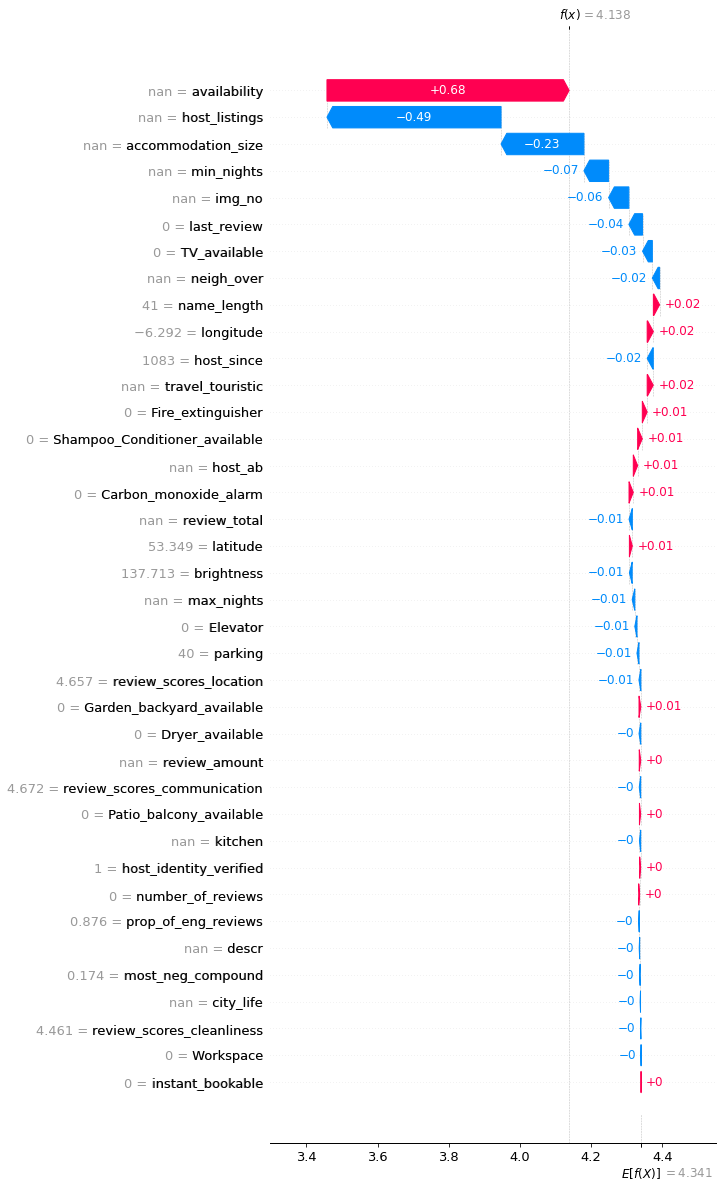

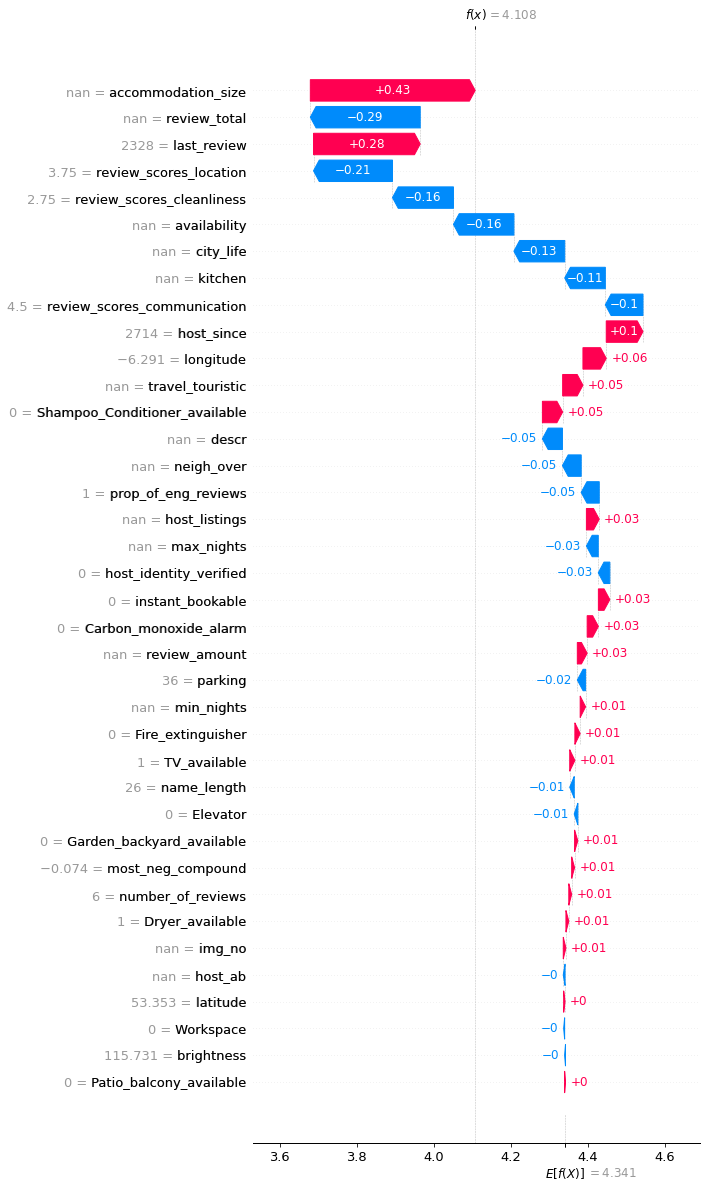

All-NaN slice encountered


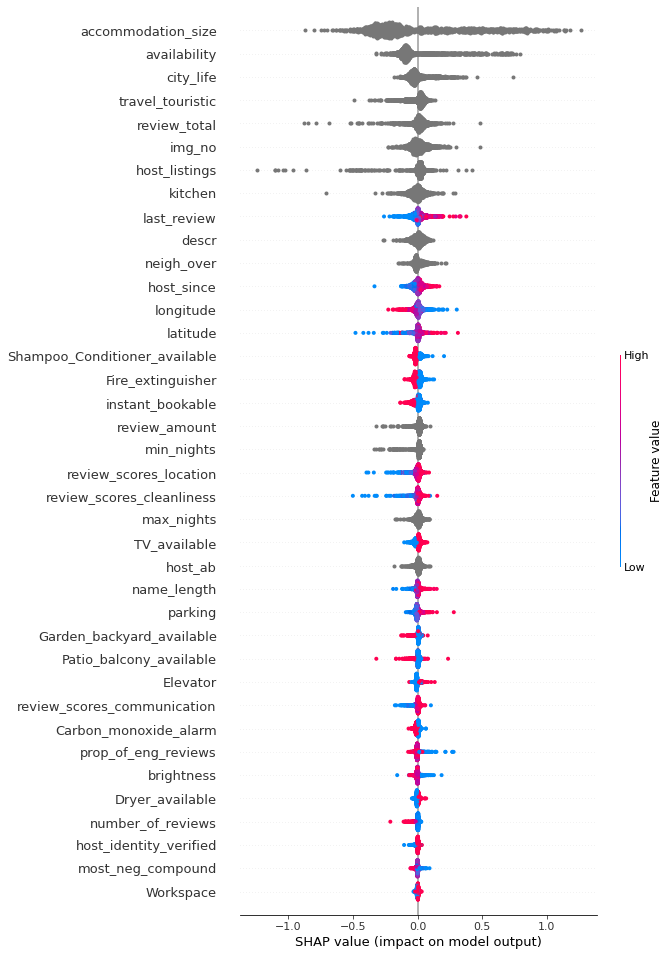

In [16]:
# PLOTS

shap_values = get_aggr_shap(shap_values)

shap.plots.waterfall(shap_values[8], max_display = 50)                    
shap.plots.waterfall(shap_values[588], max_display = 50)

shap.plots.beeswarm(shap_values, max_display=50)

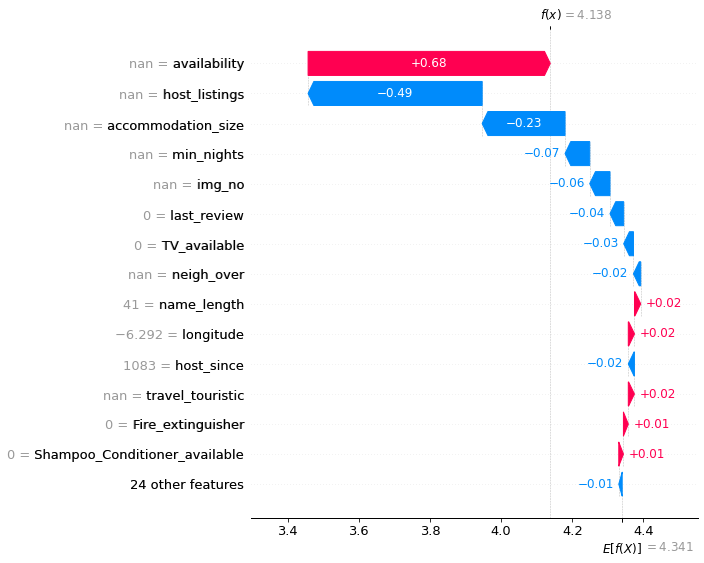

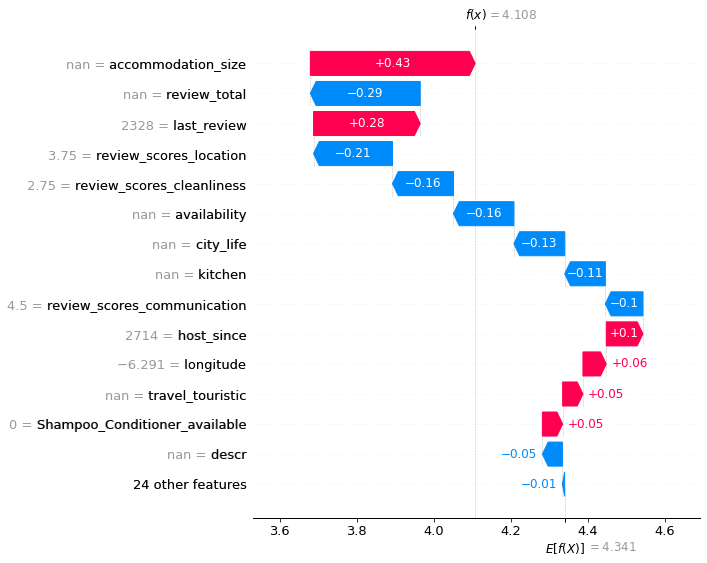

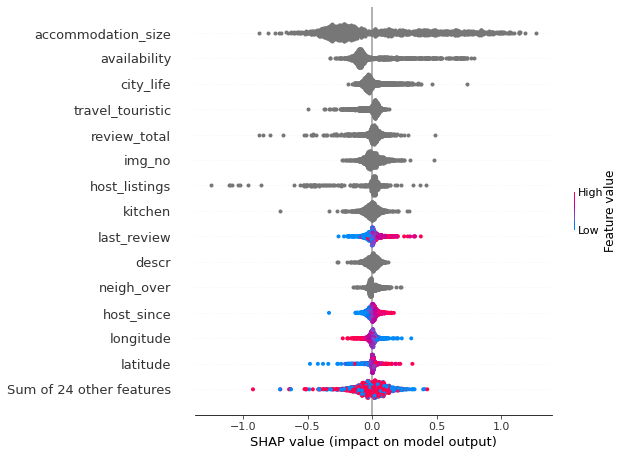

In [17]:
# PLOTS

#shap_values = get_aggr_shap(shap_values)

shap.plots.waterfall(shap_values[8], max_display = 15)                    
shap.plots.waterfall(shap_values[588], max_display = 15)

shap.plots.beeswarm(shap_values, max_display=15)

# Munich Prediction

In [20]:
X_munich, y_munich, X_munich_shap = load_data_munich_fold(fold = 4, for_dendro=True, verbose = 0)

In [21]:
munich_pred = tf.data.Dataset.from_tensor_slices({"features": X_munich, "price": y_munich})
munich_dataset = munich_pred.take(len(X_munich))
munich_dataset = munich_dataset.map(transform)
munich_dataset = munich_dataset.batch(X_munich.shape[0])

In [ ]:
y_pred = model.predict(munich_dataset)

In [22]:
model.evaluate(munich_dataset)

1/1 [==============================] - 0s 18ms/step - loss: 0.4681 - R_squared: -0.0794 - mse: 0.4681 - mae: 0.5465


[0.46807214617729187,
 -0.07939314842224121,
 0.46807214617729187,
 0.5464897155761719]

In [ ]:
explainer = shap.Explainer(model_new)
shap_values = explainer(X_munich)
#shap_values = get_aggr_shap(shap_values)
shap_values.data = X_munich_shap
shap.plots.beeswarm(shap_values, max_display=15)
